In [1]:
import math
import os
import subprocess
import uuid

from IPython.display import set_matplotlib_formats
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import networkx as nx

from mediawords.db import *

PLATFORM_MEDIA_IDS =[18362, 18346, 18370, 61164, 269331, 73449, 62926, 21936, 5816, 4429, 20448, 67324, 351789, 22299, 135076, 25373]

    
def add_partisan_retweet_to_snapshot_media(db, timespans_id, media):
    label = 'partisan_retweet'

    partisan_tags = db.query(
        """
select dmtm.*, dt.tag
    from snap.media_tags_map dmtm
        join tags dt on ( dmtm.tags_id = dt.tags_id )
        join tag_sets dts on ( dts.tag_sets_id = dt.tag_sets_id )
        join timespans t using ( snapshots_id )
    where
        dts.name = 'retweet_partisanship_2016_count_10' and
        t.timespans_id = %(a)s
        """,
        {'a': timespans_id}
    ).hashes()

    partisan_map = {pt['media_id']: pt['tag'] for pt in partisan_tags}

    for medium in media:
        medium[label] = partisan_map.get(medium['media_id'], 'null')
        
def get_media_network(db, timespans_id):
    """Get a network of media and edges for the topic."""
    media = db.query(
        """
        select m.media_id, m.name, mlc.media_inlink_count
            from media m
                join snap.medium_link_counts mlc using ( media_id )
            where
                mlc.timespans_id = %(a)s
        """,
        {'a': timespans_id}
    ).hashes()
    
    medium_links = db.query(
        "select * from snap.medium_links where timespans_id = %(a)s",
        {'a': timespans_id}
    ).hashes()
    
    media_lookup = {m['media_id']: m for m in media}

    for medium in media:
        media_lookup[medium['media_id']] = medium
        
    for medium_link in medium_links:
        medium = media_lookup[medium_link['source_media_id']]
        medium.setdefault('links', [])
        medium['links'].append(medium_link)
        
    add_partisan_retweet_to_snapshot_media(db, timespans_id, media)
        
    return media

def get_media_graph(db, media):
    """Get a networkx graph describing the media network of the topic."""
    media = get_media_network(db, timespans_id)
    
    graph = nx.Graph()
    
    [graph.add_node(m['media_id']) for m in media]
    
    media_lookup = {m['media_id']: m for m in media}

    nx.set_node_attributes(graph, media_lookup)

    for medium in media:
        if 'links' in medium:
            for e in medium['links']:
                graph.add_edge(
                    e['source_media_id'],
                    e['ref_media_id'],
                    weight=e['link_count']
                )
            
    return graph
    

db = connect_to_db()

# caravan
#timespans_id = 825739

# corona
timespans_id = 883849

# election twitter
#timespans_id = 881901

# election web
#timespans_id = 883131

media = get_media_network(db, timespans_id)
graph = get_media_graph(db, media)

print(media[0])

len(graph.nodes)


INFO mediawords.db.result.result: Slow query (1 seconds): select m.media_id, m.name, mlc.media_inlink_count from media m join [...], ({'a': 883849},)
INFO mediawords.db.result.result: Slow query (1 seconds): select dmtm.*, dt.tag from snap.media_tags_map dmtm join tags dt on ( [...], ({'a': 883849},)


{'media_id': 1383672, 'name': 'zawielkimmurem.net', 'media_inlink_count': 0, 'partisan_retweet': 'null'}


17374

In [2]:
print(graph)
graphs = nx.connected_components(graph)
graphs = sorted(graphs, key=len, reverse=True)

graph = graph.subgraph(graphs[0])
    
len(graph.nodes)


8962

In [3]:
platform_lookup = {id: True for id in PLATFORM_MEDIA_IDS}
include_nodes = []

for node in graph.nodes():
    if node not in platform_lookup:
        include_nodes.append(node)

graph = graph.subgraph(include_nodes)

In [4]:
def run_fa2_layout(graph):
    input_file = "/tmp/media-%s.gexf" % uuid.uuid4().hex
    output_template = "/tmp/media-%s" % uuid.uuid4().hex
    output_file = "%s.txt" % output_template
    
    export_graph = graph.copy()
    for node in export_graph.nodes(data=True):
        for key in list(node[1].keys()):
            del node[1][key]

    nx.write_gexf(export_graph, input_file)
    
    print("running layout...")
        
    p = subprocess.Popen(
        [
            "/usr/bin/nice",
            "/usr/bin/java",
            "-Djava.awt.headless=true",
            "-Xmx8g", 
            "-cp", "/hroberts/tmp/java-fa2/forceatlas2.jar:/hroberts/tmp/java-fa2/gephi-toolkit-0.9.2-all.jar",
            "kco.forceatlas2.Main",
            "--input", input_file,
            #"--nsteps", "1000",
            "--targetChangePerNode", "0.5",
            "--output", output_template,
            "--directed",
            "--2d"
        ],
        stdout=subprocess.PIPE,
        bufsize=1,
        universal_newlines=True
    )

    for line in p.stdout:
        print(line, end='')
        
    f = open(output_file)
    lines = f.readlines()
    
    del lines[0]
    
    positions = {}
    for line in lines:
        (i, x, y) = [float(i) for i in line.split()]
        positions[i] = (x, y)
        
    os.remove(input_file)
    os.remove(output_file)
        
    return positions
    
positions = run_fa2_layout(graph)

running layout...
100 iterations, change_per_node = 2.367338103603308
200 iterations, change_per_node = 1.6378296275468895
Finished in 239 iterations, change_per_node = 0.41779142291932436
Time = 10.046s


initial size: 8952
display size: 1000
pruned display size: 993


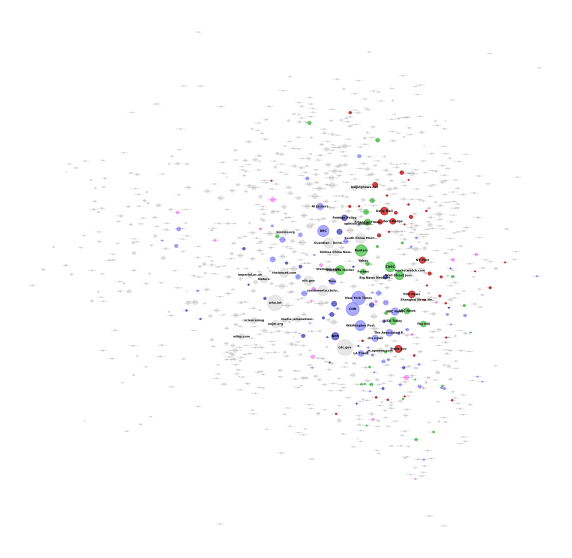

In [5]:
PARTISAN_COLORS = {
    'left': '#4040bb',
    'center_left': '#8888FF',
    'center': '#40BB40',
    'center_right': '#FF88FF',
    'right': '#BB0404',
    'null': '#DDDDDD'
}

def get_colors(graph):
    partisan_retweet = nx.get_node_attributes(graph, 'partisan_retweet')
    color_table = [PARTISAN_COLORS[partisan_retweet[n]] for n in graph.nodes]
    
    return color_table

def get_node_sizes(graph, attribute, scale):
    values = nx.get_node_attributes(graph, attribute).values()
        
    max_value = max(values)
        
    return [(v / max_value) * scale for v in values]

def get_display_subgraph_by_attribute(graph, attribute, num_nodes):
    """Get a subgraph with only the top num_nodes nodes by attribute."""
    nodes_with_values = nx.get_node_attributes(graph, attribute).items()
    
    sorted_nodes_with_values = sorted(nodes_with_values, key=lambda n: n[1], reverse=True)
    
    include_node_ids = [n[0] for n in sorted_nodes_with_values[0:num_nodes]]
    
    include_nodes = []
    for node in graph.nodes():
        if node in include_node_ids:
            include_nodes.append(node)
    
    return graph.subgraph(include_nodes)

def prune_graph_by_distance(graph, positions):
    """Get a subgraph with far flung nodes pruned.
    
    Many graphs end up with a few far flung nodes that distort the whole map.  This
    function computes the mean distances from the center of the graph and removes
    any nodes that are more than 2.5x the average distance.
    """
    center_x = sum([positions[n][0] for n in graph.nodes()]) / len(graph.nodes())
    center_y = sum([positions[n][1] for n in graph.nodes()]) / len(graph.nodes())
    
    distance_map = {}
    for node in graph.nodes():
        node_x = positions[node][0]
        node_y = positions[node][1]
        distance = math.sqrt((node_x - center_x)**2 + (node_y - center_y)**2)
        distance_map[node] = distance
    
    mean_distance = sorted(distance_map.values())[int(len(distance_map.values()) / 2)]
    max_distance = mean_distance * 2.5
    
    include_nodes = []
    for node in graph.nodes():
        if distance_map[node] <= max_distance:
            include_nodes.append(node)
            
    return graph.subgraph(include_nodes) 

def get_labels_by_attribute(graph, label_attribute, rank_attribute, iteration, num_labels):
    """Get the top num_labels labels according to rank_attribute."""
    offset = iteration * num_labels
    
    ranks = nx.get_node_attributes(graph, rank_attribute)
    
    nodes = [n[0] for n in sorted(ranks.items(), key=lambda x: x[1], reverse=True)][offset:offset + num_labels]
    
    labels = nx.get_node_attributes(graph, label_attribute)
    
    max_label_size = 16
    for k in labels.keys():
        labels[k] = labels[k][0:max_label_size] + '..' if len(labels[k]) > max_label_size else labels[k]
    
    return {n: labels[n] for n in nodes}

def draw_labels(graph, positions):
    num_cohorts = 20
    num_labeled_cohorts = 20
    cohort_size = int(len(graph.nodes()) / num_cohorts)
    for i in range(num_labeled_cohorts):
        labels = get_labels_by_attribute(graph, 'name', 'media_inlink_count', i, cohort_size)
        weight = 'bold' if i == 0 else 'normal'
        alpha = 1.0 if i == 0 else 0.5
        nx.draw_networkx_labels(
            G=graph,
            pos=positions,
            labels=labels,
            font_size=3 / (i + 1),
            font_weight=weight,
            alpha=alpha
        )
        
def rotate(x, y, d):
    """Rotate the point around (0,0) by d degrees"""
    r = math.radians(d)
    
    cosr = math.cos(r)
    sinr = math.sin(r)

    rx = (cosr * x) - (sinr * y)
    ry = (sinr * x) + (cosr * y)
    
    return (rx, ry)


def rotate_right_to_right(graph, positions):
    """Rotate the graph so that the partisan_retweet:right nodes are to the right.
    
    Return the rotated positions.
    """
    partisan = nx.get_node_attributes(graph, 'partisan_retweet')
    right_nodes = list(filter(lambda n: partisan[n] == 'right', graph.nodes()))
    
    best_rotation = 0
    max_sum_x = 0
    for rotation in range(0, 350, 10):
        rotated_positions = {n:rotate(positions[n][0], positions[n][1], rotation) for n in right_nodes}
        sum_x = sum([p[0] for p in rotated_positions.values()])
        if sum_x > max_sum_x:
            max_sum_x = sum_x
            best_rotation = rotation
    
    return {n:rotate(positions[n][0], positions[n][1], best_rotation) for n in graph.nodes()}
            
            
def draw_graph(graph, positions):
    
    print("initial size: %d" % len(graph.nodes()))
    
    graph = get_display_subgraph_by_attribute(graph, 'media_inlink_count', 1000)
    print("display size: %d" % len(graph.nodes()))

    graph = prune_graph_by_distance(graph, positions)        
    print("pruned display size: %d" % len(graph.nodes()))

    positions = {n: positions[n] for n in graph.nodes}
    
    color_table = get_colors(graph)
    
    node_sizes = get_node_sizes(graph, 'media_inlink_count', 250)

    positions = rotate_right_to_right(graph, positions)
    
    fig = plt.figure(figsize=(10,10))

    nx.draw_networkx_nodes(
        G=graph,
        pos=positions,
        node_size=node_sizes,
        with_labels=False,
        node_color=color_table,
        alpha=0.7
    )
    
    draw_labels(graph, positions)
    
    fig.set_facecolor('#FFFFFF')

    plt.axis('off')
    set_matplotlib_formats('svg')
    plt.show()
    
draw_graph(graph, positions)
